<DIV ALIGN=CENTER>

# Introduction to Clustering
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore how to effectively use the Random
Forest algorithm. First, we repeat the analysis of the Iris and
hand-written digit data used in previous notebooks, including the
[DT][l1] IPython Notebooks. However, we now switch to an ensemble
algorithm. Throughout this Notebook, you should think about how these
results from this algorithm are different than the results from previous
algorithms, especially the DT algorithm. Also, explore how changes in
the default parameters might affect the performance of this algorithm.

First, we will setup this Notebook, and then introduce the Iris data,
before making classifications for this data by using the scikit learn's
[Random Forest][rfsk] algorithm. After this, we will explore the
application of this algorithm to the handwritten digit data set.


-----
[l1]: intro2dt.ipynb
[rfsk]: http://scikit-learn.org/stable/modules/ensemble.html#forest

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----

## Iris Data

We will use the standard Iris classification data set to explore how to
use these basic classification algorithms, starting in this Notebooks
with random forests, or RF. The four primary dimensions of the
data include Sepal Length, Sepal Width, Petal Length, and Petal Width,
which can be seen from the following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. Before proceeding, we can examine
the Pandas DataFrame that contains these data.

-----

In [2]:
# We import helper code for getting and plotting the Iris data
from helper_code import iris as hi

# Now we grab the raw data, and also create a sampled grid of data.

# This code restricts the features to the top two PCA components
# This simplifies the viewing of the predited labels.

data = hi.get_data()
mdata = hi.get_mdata(data)

# Get features (x) and labels (y)
x = data[:, 0:2]
y = data[:, 2]

-----

## [Clustering][cl]

The last machine learning technique we will explore is cluster finding.
Clustering seeks to first find $N$ clusters in a data set and to
subsequently identify which cluster data belong to. While there are a
number of different approaches to clustering, one of the easiest to
understand is the k-means algorithm. In this algorithm we start with a
guess for the number of clusters (again this can be based on a priori
information or iteratively quantified). We randomly place cluster
centers in the data and determine how well the data _cluster_ to these
cluster centers. This information is used to pick new cluster centers,
and the process continues until a solution converges (or we reach a
predefined number of iterations). This process is displayed in the
following figure from Wikipedia.

![KMeans Wikipedia Image][kmi]

We can employ k-means clustering with scikit-learn by using the `KMeans`
within the `cluster` module. This requires the number of clusters to
find as an input parameter. After the model is created, we once again
fit the model to the data and subsequently obtain our model predictions.
Note how this process is unsupervised in that we do not use the label
array in this process. After we find our clusters, we plot the original
data and the new clustered data in our principal component axes to
visually quantify how well the algorithm performed.

-----
[cl]: https://en.wikipedia.org/wiki/Cluster_analysis
[km]: https://en.wikipedia.org/wiki/K-means_clustering
[kmi]: ../../Week1/notebooks/images/kmeans-wikipedia.png

In [3]:
# We will use kmeans form scikit-learn
from sklearn.cluster import KMeans

# We build our model assuming three clusters
k_means = KMeans(n_clusters=3, random_state=0)

# We fit our data to assign classes
k_means.fit(x)

# Obtain the predictions
y_pred = k_means.predict(x)

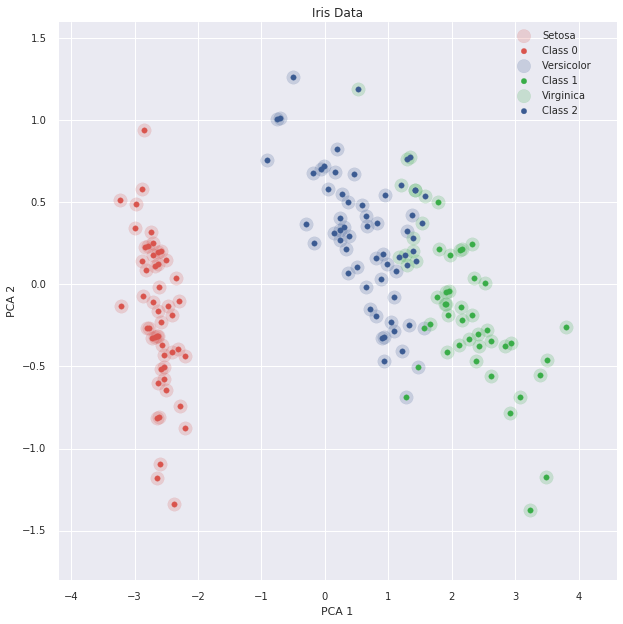

In [4]:
# Now we compare the cluster assignments to the real classes.

clr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["medium green"]]
pclr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], sns.xkcd_rgb["denim blue"]]

lbls = ['Setosa', 'Versicolor', 'Virginica']
plbls = ['Class 0', 'Class 1', 'Class 2']

cols = ['PCA1', 'PCA2', 'Species']

# Data
dt = pd.DataFrame(data, columns = cols)
# Predicted Clusters
pc = pd.DataFrame(np.concatenate((x, y_pred.reshape((150, 1))), axis=1), columns = cols)

fig, ax = plt.subplots(figsize=(10, 10))

for idx in range(3):
    
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], label=lbls[idx], alpha=0.2, s=180)

    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], color=pclr[idx], label=plbls[idx], alpha=1, s=30)

ax.set_xlim(-4.2, 4.6)
ax.set_ylim(-1.8, 1.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(0.8, 1), loc=2)

sns.despine(offset=5, trim=True)

-----

## Student Activity

In the preceding cells, we used a random forest model to predict
classifications for the Iris Data. Now that you have run the Notebook
once, go back and make the following changes to see how the results
change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the Random Forest algorithm, for
example, `criterion`, `max_features`, `bootstrap`, `oob`, or
`max_depth`. Read the code documentation to learn about the default
parameters.
3. Change the parameters in the RF classifier in the ROC code block and
see how the curves change, for example, `n_estimators` and `max_depth`.

How does the two-dimensional figure compare to the same figure in the DT
Notebook?

-----

-----

## [Random Forest][rf]

The previous algorithms all perform well for this small test data set.
But in more complex data, 
-----

[rf]: https://en.wikipedia.org/wiki/Random_forest

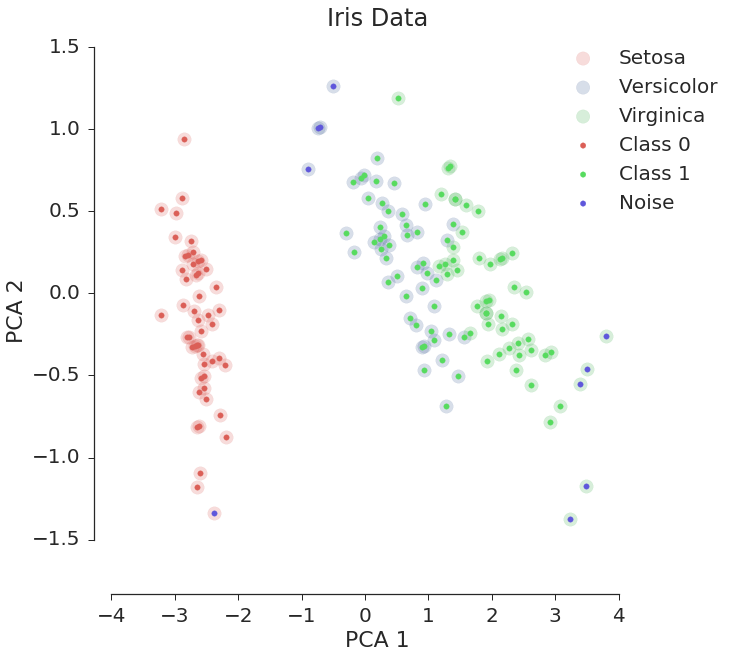

In [5]:
sns.set(style="ticks", font_scale=2.0)

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, metric='euclidean', min_samples=10)
db.fit(x)

dblbls = set(db.labels_)
dbclrs = sns.hls_palette(len(dblbls))
dbcls = ['Class {0}'.format(idx) if idx >= 0 else 'Noise' for idx in dblbls]

pc = pd.DataFrame(np.concatenate((x, db.labels_.reshape((150, 1))), axis=1), columns = cols)

fig, ax = plt.subplots(figsize=(10, 10))

for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], label=lbls[idx], alpha=0.2, s=180)

for idx in list(dblbls):
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], color=dbclrs[idx], label=dbcls[idx], alpha=1, s=30)

ax.set_xlim(-4.2, 4.6)
ax.set_ylim(-1.8, 1.6)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(0.8, 1), loc=2)

sns.despine(offset=5, trim=True)
sns.set(font_scale=1.0)

-----

## Student Activity

In the preceding cells, we used a Random Forest model to predict
classifications for the digit data. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the Random Forest
algorithm. Read the code documentation to learn about the default
parameters.
3. Change the RF algorithm to an [Extra Trees Classifier][etc].

Finally can you explain (feel free to use the class forums) why the
model performed in the  manner it did for the _fake_ digits
(particularily in comparison to the DT algorithm)?

-----
[etc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

## Handwritten Digits

Now we switch to a second type of data and explore Random Forest
classification applied to handwritten digits. First we will load the
data and review some of the sample. After which, we will apply an RF
classification to these data and explore the resulting predictions.

-----

Total number of samples = 1797


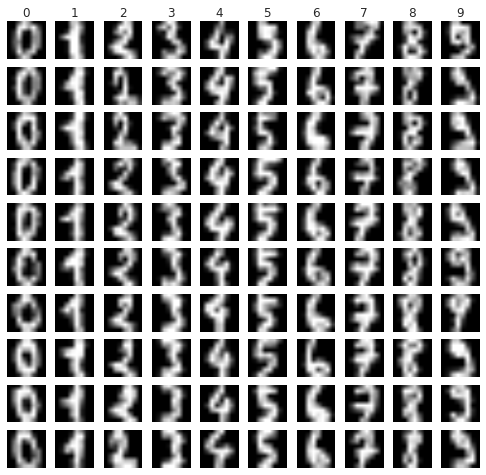

In [6]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

-----

### Classification of image data

Now that these data are loaded, we can apply a Random Forest classifier
to this problem. Below we employ this model, and show the classification
score, the classification report, and the confusion matrix.

-----

In [7]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Testing parameters
ncps = 25

# Compute PCA for digit data
pca = PCA(n_components=ncps, copy=True)
data = pca.fit_transform(x)

# We build our model assuming three clusters
k_means = KMeans(n_clusters=10)

# We fit our data to assign classes
k_means.fit(data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Actual : Predicted
  1    :     4
  1    :     4
  1    :     4
  1    :     4
  1    :     4
  1    :     4


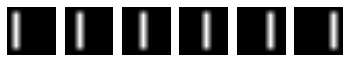

In [8]:
# Test on our ones
ones = hd.make_ones()
hd.plot_numbers(ones)

print('Actual : Predicted')

for one in ones:
    print('  1    :     {0}'.format(k_means.predict(pca.transform(ones))[0])) 

Actual : Predicted
  7    :     8
  7    :     8
  7    :     8


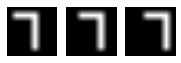

In [9]:
# Now test on our sevens
sevens = hd.make_sevens()
hd.plot_numbers(sevens)

print('Actual : Predicted')
for seven in sevens:
    print('  7    :     {0}'.format(k_means.predict(pca.transform(sevens))[0])) 

-----

## Student Activity

In the preceding cells, we used a Random Forest model to predict
classifications for the digit data. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the Random Forest
algorithm. Read the code documentation to learn about the default
parameters.
3. Change the RF algorithm to an [Extra Trees Classifier][etc].

Finally can you explain (feel free to use the class forums) why the
model performed in the  manner it did for the _fake_ digits
(particularily in comparison to the DT algorithm)?

-----
[etc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier

-----

### Model Evaluation

The Random Forest model performed in a reasonable manner, but what about
on completely blind data. We can test the model by _making_ new data.
Below we use methods in the helper code to make _fake_ data, in this
case images of **one** and **seven**. We display the _fake_ images, and
then the results of our model classifying these new data.

-----



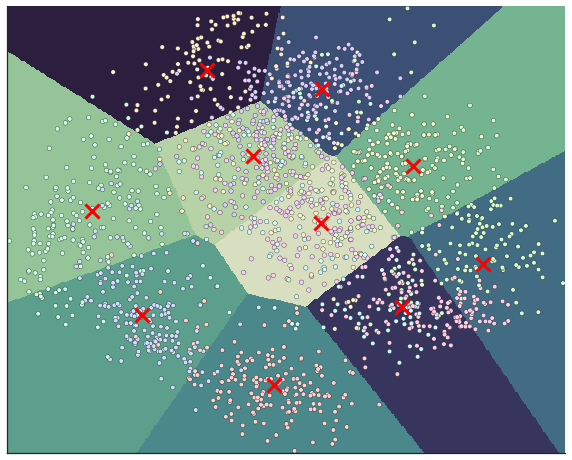

In [10]:
from matplotlib.colors import ListedColormap

cmp_bkg = ListedColormap(sns.cubehelix_palette(10, start=.5, rot=-.75))
cmp_pts = ListedColormap(sns.hls_palette(10, l=.9, s=.9))

# Compute PCA for digit data
pca = PCA(n_components=2, copy=True)
data = pca.fit_transform(x)

# We build our model assuming ten clusters
k_means = KMeans(n_clusters=10)

# We fit our data to assign classes
k_means.fit(data)

# Step size of the mesh. 
grid_size = 500

x_min, x_max = data[:, 0].min() - .25, data[:, 0].max() + .25
y_min, y_max = data[:, 1].min() - .25, data[:, 1].max() + .25

# Meshgrid gives two 2D arrays of the ppoints
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                     np.linspace(y_min, y_max, grid_size))

zz = k_means.predict(np.c_[xx.ravel(), yy.ravel()])

sns.set(style="ticks", font_scale=2.0)
fig, ax = plt.subplots(figsize=(10,8))

plt.pcolormesh(xx, yy, zz.reshape((grid_size, grid_size)), cmap=cmp_bkg)
    
# Draw the points
plt.scatter(data[:, 0], data[:, 1], c = y, s=20, cmap=cmp_pts)

# Plot the centroids as a red X
ctrs = k_means.cluster_centers_
plt.scatter(ctrs[:, 0], ctrs[:, 1], marker='x', s=200, linewidths=3, color='r')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])

sns.despine(left=False, bottom=False)

plt.show()

-----

## Student Activity

In the preceding cells, we used a Random Forest model to predict
classifications for the digit data. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the Random Forest
algorithm. Read the code documentation to learn about the default
parameters.
3. Change the RF algorithm to an [Extra Trees Classifier][etc].

Finally can you explain (feel free to use the class forums) why the
model performed in the  manner it did for the _fake_ digits
(particularily in comparison to the DT algorithm)?

-----
[etc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier